# Import

In [1]:
!pip install -q underthesea

In [2]:
import numpy as np
import pandas as pd
import nltk, re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Preprocessing tabular data

In [3]:
df = pd.read_csv('/kaggle/input/vietnamese-text-classification-dataset/train.csv', names=['label', 'comment'])
df.head()

,label,comment
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3040 non-null   int64 
 1   comment  3040 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.6+ KB


In [5]:
df.isnull().sum()

label      0
comment    0
dtype: int64

In [6]:
df.isna().sum()

label      0
comment    0
dtype: int64

In [7]:
df = df.drop_duplicates('comment')
df = df.reset_index(drop=True)
df.shape

(2998, 2)

In [8]:
df

,label,comment
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng
...,...,...
2993,1,Nhanh hết pin Không biết phải lỗi hay không Mà...
2994,0,không có bộ thu đi kèm Vừa nhận hàng xong tức ...
2995,0,Cũng bình thường Không mạnh như kỹ vọng Chắc t...
2996,2,tốt tốt đang tiền khi bỏ ra để mua giao hàng n...


# EDA

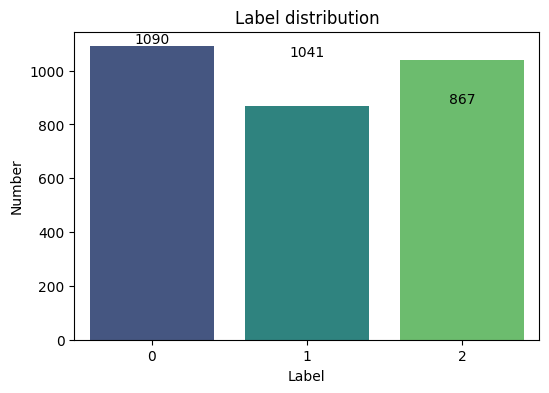

In [9]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,round(y[i]),round(y[i]), ha='center', va='bottom')

label_counts = df['label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Label distribution')
plt.xlabel('Label')
plt.ylabel('Number')
addlabels(label_counts.index, label_counts.values)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


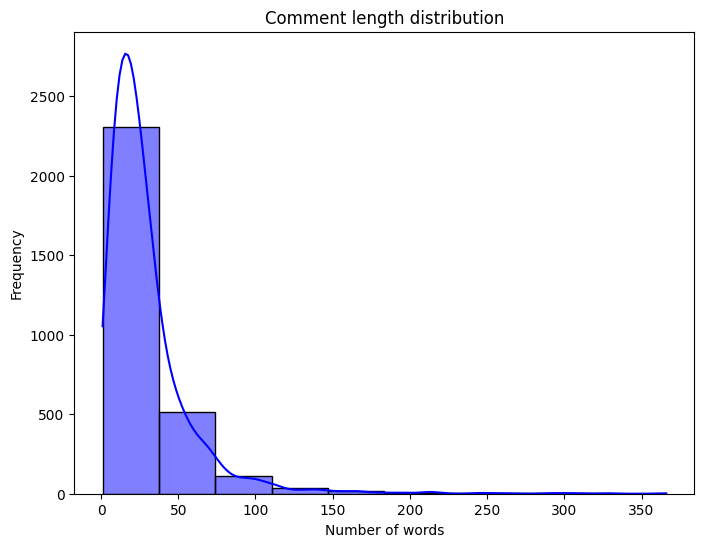

In [10]:
df['comment_length'] = df['comment'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,6))
sns.histplot(df['comment_length'], bins=10, kde=True, color='blue')
plt.title('Comment length distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

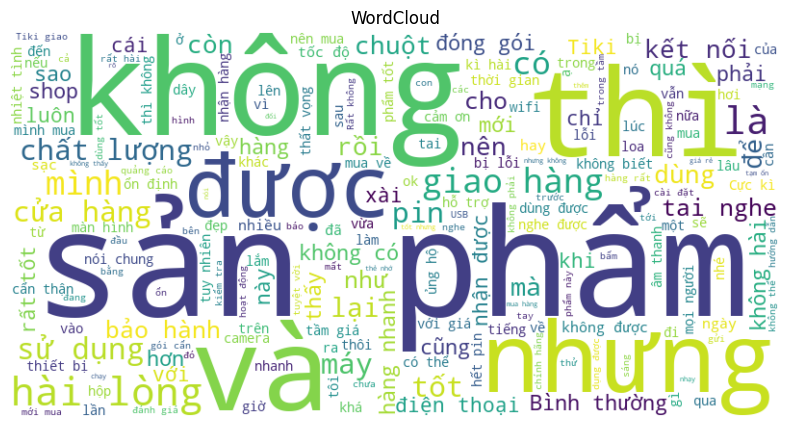

In [11]:
all_comments = ' '.join(df['comment'].values)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud')
plt.show()

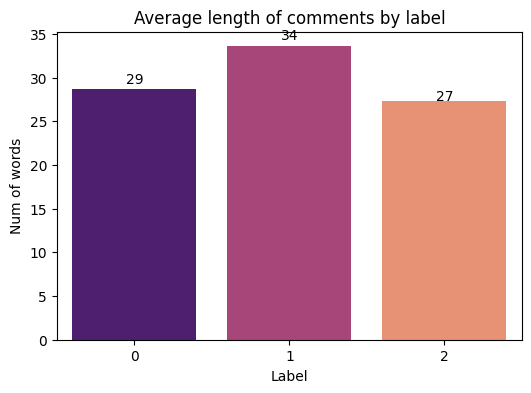

In [12]:
avg_length_by_label = df.groupby('label')['comment_length'].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=avg_length_by_label.index, y=avg_length_by_label.values, palette='magma')
plt.title('Average length of comments by label')
plt.xlabel('Label')
plt.ylabel('Num of words')
addlabels(avg_length_by_label.index, avg_length_by_label.values)
plt.show()

# Preprocessing text data

In [13]:
labels = list(df['label'])
labels[:10]

[0, 0, 0, 0, 2, 1, 0, 1, 0, 0]

In [14]:
comments = list(df['comment'])
comments[:10]

['máy dùng hay bị đơ máy',
 'chỉ có dây cáp nguồn không có adapter sao sử dụng chỉ có dây cáp nguồn không có adapter sao sử dụng hàng tiki training gì kì cục vậy ',
 'Chất lượng quá kém Mới dùng được 2 ngày loa bass có âm thanh rè rè dù không mở gì Không tin tưởng được chất lượng',
 'Usb tôi vừa mới nhận usb này Rất bực bội vì cái nắp usb này rất cứng không thể mở ra được Và cái hộp đựng usb này dường như bị ai đó cắt ra trước đó',
 'Tuyệt vời. Hàng FPT cửa hàng',
 'Chưa đo đúng bước chân rõ Nhiều khi gián đoạn chưa hài lòng Hàng không có tiếng việt nên rất khó để tìm hiểu về các hoạt động của máy',
 'phủ sóng thấp quá đi khoảng 3 4m là mất sóng',
 'Kết nối tốt Mối nối không khít gây đau tai 1 Kết nối: nhiều bạn cũng nói vấn đề này rồi kết nối tốt tiện dụng 2 Mối nối:   Có 1 bạn cũng gặp trường hợp giống mình mối nối không khớp với nhau ở một số điểm Đeo vào là thấy hơi hơi khó chịu đeo lâu gây đau tai cực   Ban đầu mình không nghĩ đây là vấn đề lớn nên không liên hệ đổi trả Bây giờ có

In [15]:
def normalize(text):
    # remove html
    text = re.sub(r'<[^>]*>', '', text)
    
    # remove punctuation
    text = re.sub(f'[{string.punctuation}₫—℅\d\n]', '', text)
    
    # remove emojis
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) 
    
    # lowercase
    text = text.lower()
    
    # remove redundant white space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [16]:
comments = [normalize(cmt) for cmt in comments]
comments[:10]

['máy dùng hay bị đơ máy',
 'chỉ có dây cáp nguồn không có adapter sao sử dụng chỉ có dây cáp nguồn không có adapter sao sử dụng hàng tiki training gì kì cục vậy',
 'chất lượng quá kém mới dùng được ngày loa bass có âm thanh rè rè dù không mở gì không tin tưởng được chất lượng',
 'usb tôi vừa mới nhận usb này rất bực bội vì cái nắp usb này rất cứng không thể mở ra được và cái hộp đựng usb này dường như bị ai đó cắt ra trước đó',
 'tuyệt vời hàng fpt cửa hàng',
 'chưa đo đúng bước chân rõ nhiều khi gián đoạn chưa hài lòng hàng không có tiếng việt nên rất khó để tìm hiểu về các hoạt động của máy',
 'phủ sóng thấp quá đi khoảng m là mất sóng',
 'kết nối tốt mối nối không khít gây đau tai kết nối nhiều bạn cũng nói vấn đề này rồi kết nối tốt tiện dụng mối nối có bạn cũng gặp trường hợp giống mình mối nối không khớp với nhau ở một số điểm đeo vào là thấy hơi hơi khó chịu đeo lâu gây đau tai cực ban đầu mình không nghĩ đây là vấn đề lớn nên không liên hệ đổi trả bây giờ có cơ hội so với tai 

# TF-IDF Weighted Word2Vec + SVM (Word2Vec create negative values so cannot pass to NB model

In [28]:
X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42, stratify=labels)

In [29]:
print(len(X_train), len(X_test))

2398 600


In [30]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
tfidf_feature_names = tfidf.get_feature_names_out()
tfidf_feature_names

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['a hame', 'a pin', 'a z', ..., 'ứng dụng', 'ứng dụngle', 'ỷ y'],
      dtype=object)

In [31]:
tfidf_feature_names[55:100]

array(['banh', 'bao', 'bao bì', 'bao bọc', 'bao giờ', 'bao gói', 'bao h',
       'bao hanh', 'bao kiện', 'bao lâu', 'bao mượt', 'bao mắc',
       'bao nhiêu', 'bao test', 'bas', 'bass', 'bass lở', 'bass tai',
       'bassthất vọng', 'battery', 'bay', 'been', 'ben', 'benh', 'bi',
       'bi gã', 'bi hư', 'bi mòn', 'bin', 'bin kính', 'bin tai', 'binh',
       'bit', 'bits', 'biến nhạy', 'biết', 'biết bao nhiêu', 'biết điều',
       'biếtsản phẩm', 'blah', 'bluetooth', 'bmiu', 'body', 'bolero',
       'bong'], dtype=object)

In [32]:
word2vec_model = Word2Vec([word_tokenize(cmt) for cmt in X_train], vector_size=100, window=5, min_count=1)

In [33]:
word2vec_model.wv.index_to_key[:10]

['không', 'được', 'hàng', 'tốt', 'thì', 'có', 'mình', 'rất', 'sản phẩm', 'mua']

In [34]:
def document_vector(doc):
    words = word_tokenize(doc)
    tfidf_weights = dict(zip(tfidf_feature_names, tfidf.idf_))
    doc_vec = np.zeros(word2vec_model.vector_size)
    total_weight = 0
    for word in words:
        if word in word2vec_model.wv:
            word_vec = word2vec_model.wv[word]
            tfidf_weight = tfidf_weights.get(word, 0)
            doc_vec += word_vec * tfidf_weight
            total_weight += tfidf_weight
    return doc_vec / total_weight if total_weight != 0 else doc_vec

In [35]:
document_vectors_train = np.array([document_vector(cmt) for cmt in X_train])
document_vectors_test = np.array([document_vector(cmt) for cmt in X_test])

In [36]:
document_vectors_train[0]

array([-0.09467503,  0.23168024,  0.03872215, -0.0048129 ,  0.08688362,
       -0.42197412,  0.18287982,  0.6307551 , -0.27068497, -0.15469238,
       -0.11695535, -0.45364663,  0.09782981,  0.10767888, -0.02822296,
       -0.10617762,  0.00151935, -0.30370766, -0.0467545 , -0.61125599,
        0.08288953,  0.22412085,  0.18529477, -0.13953343, -0.07890326,
        0.0639654 , -0.2040654 , -0.12181169, -0.17506514, -0.00836854,
        0.20549193,  0.01941561,  0.09108634, -0.18306149, -0.20762935,
        0.35094668, -0.02176908, -0.31097685, -0.19446103, -0.54935067,
       -0.01559902, -0.31753795, -0.11374294, -0.05234024,  0.20880489,
       -0.11071952, -0.20628334, -0.06673753,  0.21257658,  0.06231525,
        0.14977491, -0.24419155,  0.0261706 ,  0.01309417, -0.11015274,
        0.14136298,  0.04881943, -0.02801436, -0.30941049,  0.06643424,
        0.09431991,  0.01145776, -0.00548611, -0.06586085, -0.26296905,
        0.26157399,  0.14852868,  0.16035602, -0.42891199,  0.29

In [43]:
svm_model = SVC(kernel='linear')
    
svm_model.fit(document_vectors_train, y_train)
y_pred = svm_model.predict(document_vectors_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.92      0.64       218
           1       0.00      0.00      0.00       174
           2       0.69      0.62      0.65       208

    accuracy                           0.55       600
   macro avg       0.39      0.51      0.43       600
weighted avg       0.42      0.55      0.46       600



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TFIDF + SVM/NB

In [41]:
svm_model = SVC(kernel='linear')
    
svm_model.fit(X_train_tfidf, y_train)
y_pred = svm_model.predict(X_test_tfidf)

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       218
           1       0.73      0.63      0.67       174
           2       0.87      0.84      0.85       208

    accuracy                           0.80       600
   macro avg       0.79      0.78      0.78       600
weighted avg       0.79      0.80      0.79       600



In [42]:
nb_model = MultinomialNB()
    
nb_model.fit(X_train_tfidf, y_train)
y_pred = nb_model.predict(X_test_tfidf)

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       218
           1       0.82      0.41      0.54       174
           2       0.79      0.88      0.83       208

    accuracy                           0.76       600
   macro avg       0.77      0.74      0.73       600
weighted avg       0.77      0.76      0.74       600

